
# Lab 01

## Introdução

O objetivo deste laboratório é explorar diferentes técnicas utilizadas para classificação em aprendizado de máquina, utilizaremos modelos clássicos de classificação e iremos introduzir um modelo simples de rede neural para resolver o mesmo problema.

O intuito desta atividade é a familiarização das bibliotecas em Python utilizadas por padrão na análise de dados assim como mostrar que o aprendizado de máquina é algo simples e acessível a qualquer um.

## Sobre o DataSet

Para este laboratório, vamos brincar com o dataset [Breast Cancer Wisconsin](http://mlr.cs.umass.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29).

Este dataset é público e foi disponibilizado em novembro de 1995, o objetivo é classificar tumores como benignos ou malignos considerando valores obtidos por análise de imagem.

Mais informações sobre este dataset e seus valores podem ser consultadas [neste link](http://mlr.cs.umass.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

## Bibliotecas utilizadas

### NumPy

[NumPy](http://www.numpy.org/) é uma famosa biblioteca utilizada para fins científicos, facilita a criação, manipulação e cálculos envolvendo vetores e matrizes.

### Pandas

[Pandas](https://pandas.pydata.org/) provê uma interface que nos permite manipular dados de forma similar ao que faríamos utilizando uma tabela de Excel. Nos devolve uma estrutura de dados chamada [DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html), onde organizamos os dados em linhas e colunas.

### MatPlotLib

[MatPlotLib](https://matplotlib.org/) é uma biblioteca para plotagem de gráficos. Suas ferramentas permitem customização completa dos gráficos gerados.

### Seaborn

[Seaborn](https://seaborn.pydata.org/) provê uma camada _high-level_ de abstração para a utilização da biblioteca Matplotlib, ou seja, é um facilitador.

### Scikit-Learn

[Scikit-Learn](http://scikit-learn.org/stable/) é uma das principais bibliotecas utilizadas para machine learning em Python, é open source e mantida por diversas instituições de ensino.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', None)

### Importando os dados para uma estrutura de DataFrame

A biblioteca Pandas possui métodos facilitadores para a importação de vários tipos de fontes de dados em um DataFrame. Neste laboratório vamos utilizar um arquivo no formato csv ([**C**omma-**S**eparated **V**alues](https://pt.wikipedia.org/wiki/Comma-separated_values)).

Para ter uma visão de todos os facilitadores de importação como quais parâmetros de formatação podemos utilizar para importar estes dados, veja a [documentação da biblioteca](https://pandas.pydata.org/pandas-docs/stable/io.html).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pgiaeinstein/otmz-mlp/master/bcw.data.csv', sep=',')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


Veja que quando imprimo o dataframe completo ele me mostra uma quantidade de 60 itens sendo os 30 primeiros e os 30 últimos da coleção.

Essa forma de visualizar nem sempre é necessária e pode poluir nossa documentação. Para uma visão mais controlada do Dataframe, podemos utilizar o método [`head()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html) que imprime, por padrão, as primeiras 5 linhas de informação.

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


O método aceita como argumento principal o número de linhas que desejamos imprimir, veja no exemplo abaixo quando solicitamos que as 32 linhas iniciais sejam impressas em nosso documento.

In [4]:
df.head(32)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.049040,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.71190,0.26540,0.4601,0.11890,NaN
1,842517,M,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.013080,0.01860,0.013400,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.24160,0.18600,0.2750,0.08902,NaN
2,84300903,M,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.040060,0.03832,0.020580,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.45040,0.24300,0.3613,0.08758,NaN
3,84348301,M,11.420,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.074580,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.68690,0.25750,0.6638,0.17300,NaN
4,84358402,M,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.024610,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.40000,0.16250,0.2364,0.07678,NaN
5,843786,M,12.450,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.033450,0.03672,0.011370,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.53550,0.17410,0.3985,0.12440,NaN
6,844359,M,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.013820,0.02254,0.010390,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.37840,0.19320,0.3063,0.08368,NaN
7,84458202,M,13.710,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.030290,0.02488,0.014480,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.26780,0.15560,0.3196,0.11510,NaN
8,844981,M,13.000,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.035020,0.03553,0.012260,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.53900,0.20600,0.4378,0.10720,NaN
9,84501001,M,12.460,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.072170,0.07743,0.014320,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.10500,0.22100,0.4366,0.20750,NaN


### Modificando o dataframe

Para uma análise inicial dos dados, outro método interessante é o [`info()`](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.info.html), este método imprime um resumo quantitativo e qualitativo além da estrutura completa de nosso Dataframe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

Vamos entender o que é impresso acima:

Temos 569 linhas de informação neste dataframe, iniciando no índice 0 até o índice 568. Nestas 569 entradas temos 33 atributos por linha, ou seja, temos 33 colunas.

Verifique que o método sumariza para cada linha, o nome de sua coluna, o total de valores não nulos nesta coluna assim como também o tipo de dado que a coluna guarda.

Repare na coluna `Unnamed: 32`; Está coluna possui 0 valores não nulos, ou seja, todos os valores desta coluna são nulos e devem ser desconsiderados pois não nos ajuda em nada neste laboratório.

Além da coluna `Unnamed: 32`, este dataframe possui outra coluna `id` que não faz sentido para este laboratório.

Por último, temos um resumo dos tipos de dados presentes no dataframe e também qual o tamanho em memória ocupado por este dataframe.

O método [`drop()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html) permite eliminar colunas ou linhas do nosso dataframe, no caso, vamos remover as colunas `Unnamed: 32` e `id` como dito acima e utilizaremos o argumento `inplace = True` para modificar o objeto em que estamos utilizando o método.

Por segurança, vamos criar uma cópia do objeto original e salvaremos na variável `df_inicial`.

In [6]:
# vou criar uma cópia do dataframe inicial por segurança
df_inicial = df

# vamos remover as colunas
df.drop(columns = ['id', 'Unnamed: 32'], inplace=True)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Reparem na coluna `diagnosis`, esta coluna é chamada de *TARGET*, ou seja, é a nossa coluna de saída para nosso modelo de classificação.

Ela possui dois valores em formato `char` (**M** e **B**), para facilitar nossa vida, vamos modificar essa variável para um valor numérico.

Criaremos um dicionário auxiliar para o método [`map()`](http://book.pythontips.com/en/latest/map_filter.html) onde vamos classificar a letra **B** (Benigno) como **0** e a letra **M** (Maligno) como **1**.

In [8]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [9]:
label = {
    'B' : 0,
    'M' : 1
}

df['diagnosis'] = df['diagnosis'].map(label)
df

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Depois desta transformação, agora nossa coluna de saída possui valores numéricos distintos (0 e 1).

Vamos analisar de forma mais estatística nosso dataframe agora, para isso, utilizamos o método [`describe()`](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.describe.html).

Este método retorna um resumo estatístico de nosso dataframe, por coluna, desconsiderando valores nulos.

In [10]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Escolhendo nossas Features

Temos 3 tipos de medidas neste dataset: Mean, SE e Worst. É importante entender como estes valores se comunicam.

Para alguns modelos clássicos utilizados em aprendizado de máquina, temos problemas quanto maior for o número de entradas e de colunas, característica esta que é o inverso quando comparada a um modelo de rede neural, por exemplo.

Entendendo isso vamos escolher variáveis de *input* que beneficiem nossa tarefá de classificação, sem utilizar nenhum modelo auxiliar para selecionar estas variáveis.

Separamos então nossas colunas em 3 tipos distintos: Mean, SE e Worst. Após essa separação, vamos analisar cada grupo buscando possíveis correlações entre estas variáveis.

In [11]:
# vamos criar um dataframe excluindo a coluna 'diagnosis':
df_parcial = df.iloc[:, 1:]
df_parcial.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [12]:
# Neste novo dataframe, vamos listar as colunas que restaram:
df_parcial.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Verifiquem que os 3 grupos de medidas estão em ordem, temos então levando como base o array acima:

#### Variáveis do tipo MEAN:
> Posição 0 até posição 9 do array.

#### Variáveis do tipo SE:
> Posição 10 até posição 19 do array.

#### Variáveis do tipo WORST:
> Posição 20 até posição 29 do array.

Vamos separar nossas features por tipo, criando listas com as colunas de interesse para cada tipo de variável.

In [13]:
f_mean  = list(df_parcial.columns[:10])
f_se    = list(df_parcial.columns[10:20])
f_worst = list(df_parcial.columns[20:])

In [14]:
f_mean

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean']

In [15]:
f_se

['radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se']

In [16]:
f_worst

['radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

Outro aspecto importante que devemos sempre levar em consideração é como as colunas se correlacionam, uma correlação forte entre variáveis tende a divergir o resultado do modelo em alguns casos.

Agora vamos obter a matriz de correlação destas variáveis.

In [17]:
correlacao = df_parcial[f_mean].corr()
correlacao

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000


Lembrando que quanto maior a proximidade do valor entre 1 e -1, maior é a correlação entre as duas colunas para facilitar a visualização desta matriz, algo que é muito utilizado é um gráfico do tipo HeatMap.

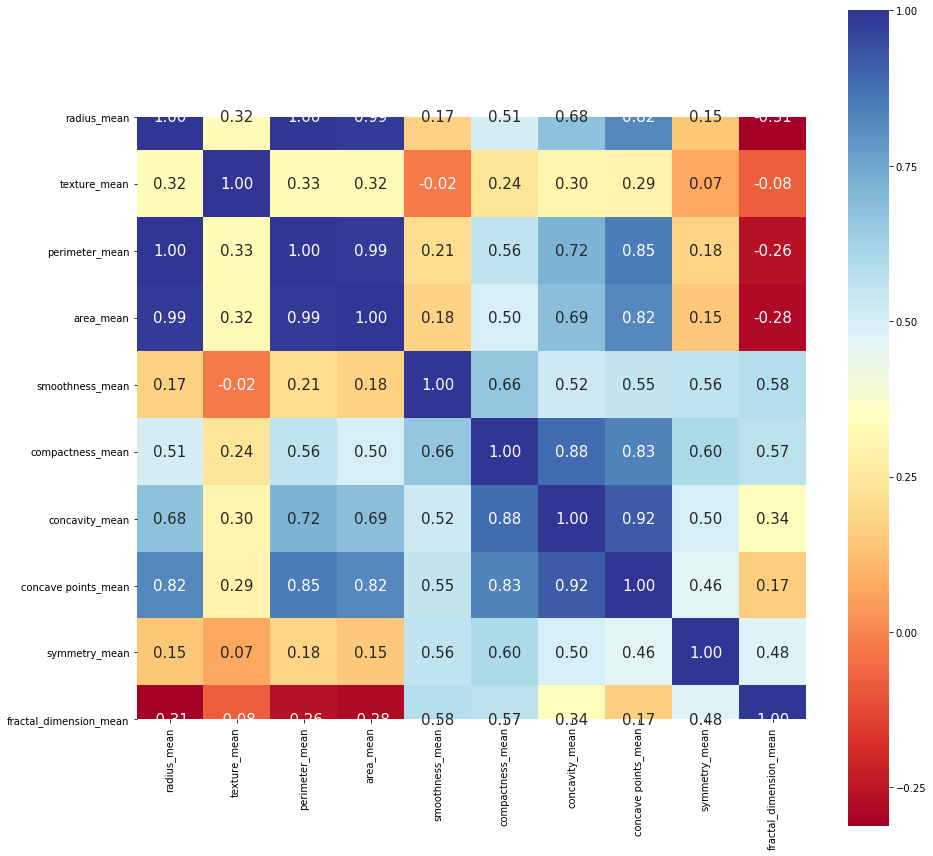

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlacao, xticklabels = f_mean, yticklabels= f_mean, cbar = True, square = True, annot = True, fmt = '.2f', annot_kws={ 'size' : 15}, cmap = 'RdYlBu', ax = ax)

#### Interpretando o gráfico

As observações aqui são simples, vamos remover de nossa base, todos os campos que tem forte correlação!

Verifique que existem 2 "quadrados" onde é possível verificar forte correlação entre os campos: `radius_mean`, `perimeter_mean` e `area_mean` formam o primeiro "quadrado" e os campos `compactness_mean`, `concavity_mean` e `concavepoint_mean` formam o segundo.

Destes dois conjuntos, escolhemos um de cada e seguimos com nossa analise.

Do primeiro grupo, vemos que `area_mean` tem os menores valores de correlação com as demais colunas, vamos escolher esta *feature* neste conjunto.

Do segundo conjunto, vemos que `compactness_mean` tem os menores valores, então seguiremos com ele.

Nossa lista de colunas final será:

In [23]:
features_mean = ['texture_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean']

#### Criando dataframes separados entre features e meta

Como já temos nossas features iniciais, podemos agora criar dois vetores, um com nossas *features* escolhidas e outro chamado de *target*, ou seja, com a classificação para cada linha de nosso dataset.

In [24]:
features = df[features_mean]
features.head()

,texture_mean,area_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean
0,10.38,1001.0,0.11840,0.27760,0.2419,0.07871
1,17.77,1326.0,0.08474,0.07864,0.1812,0.05667
2,21.25,1203.0,0.10960,0.15990,0.2069,0.05999
3,20.38,386.1,0.14250,0.28390,0.2597,0.09744
4,14.34,1297.0,0.10030,0.13280,0.1809,0.05883


In [25]:
target = df['diagnosis']
target.head()

0    1
1    1
2    1
3    1
4    1
Name: diagnosis, dtype: int64

#### Separando nossa amostra em treino e teste

Vamos separar agora a nossa base entre uma base de treino e uma base de teste.

In [26]:
seed = 4

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = seed)

Vamos criar duas funções que irão nos auxiliar com o treino, a predição e a exibição dos resultados de nossas predições.

In [27]:
def calcula_resultados(pred_output, real_output):
    cm  = confusion_matrix(real_output, pred_output)
    acc = accuracy_score(real_output, pred_output)
    f1  = f1_score(real_output, pred_output)
    ps  = precision_score(real_output, pred_output)
    rs  = recall_score(real_output, pred_output)
    
    return {
        'matrix'   : cm,
        'accuracy' : acc,
        'f1'       : f1,
        'ps'       : ps,
        'rs'       : rs
    }

def testa_modelo(modelo, X_train, X_test, Y_train, Y_test):
    modelo.fit(X_train, Y_train)
    pred_output = modelo.predict(X_test)
    response = calcula_resultados(pred_output, Y_test)
    
    print('-----------------------------')
    print('Accuracy : {}'.format(response['accuracy']))
    print('F1 : {}'.format(response['f1']))
    print('Precision : {}'.format(response['ps']))
    print('Recall : {}'.format(response['rs']))
    print('-----------------------------')
    sns.heatmap(response['matrix'], annot = True, cmap = 'winter')

### Modelos

#### SVM (Support Vector Machine)

Uma [**SVM**](https://pt.wikipedia.org/wiki/M%C3%A1quina_de_vetores_de_suporte) é um excelente método para se testar em primeiro lugar quando não se tem nenhum conhecimento prévio sobre um domínio. Três propriedades tornam a SVM atraente:

1. Constroem um **separador de margem máxima**:

![SVM01](https://github.com/pgiaeinstein/otmz-mlp/raw/master/img/svm01.jpg)
![SVM01](https://github.com/pgiaeinstein/otmz-mlp/raw/master/img/svm02.png)

2. Criam uma separação linear em hiperplano, mas tem a capacidade de entender dados em um espaço de dimensão superior, usando o **truque de kernel**.

![SVM01](https://github.com/pgiaeinstein/otmz-mlp/raw/master/img/svm03.png)

3. Uma SVM é **não paramétrica**, ou seja, existe a necessidade em guardar os exemplos de treinamento. Porém, na prática, acabam guardando apenas uma **pequena fração do número de exemplos**.

![SVM01](https://github.com/pgiaeinstein/otmz-mlp/raw/master/img/svm04.png)

-----------------------------
Accuracy : 0.7807017543859649
F1 : 0.5283018867924528
Precision : 0.7368421052631579
Recall : 0.4117647058823529
-----------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


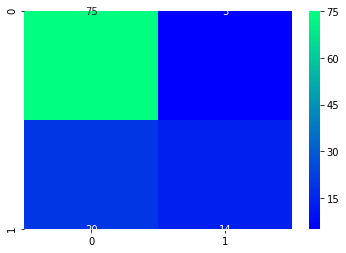

In [28]:
svc_model = SVC()
testa_modelo(svc_model, X_train, X_test, Y_train, Y_test)

#### Padronização dos dados

Já discutimos que alguns algoritmos sofrem com dados em escalas que divergem muito, vamos ver este conceito na prática.

Reparem na distribuição de nossas features atualmente:

In [29]:
X_train.describe()

,texture_mean,area_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,19.275385,654.948791,0.096733,0.104282,0.181592,0.062792
std,4.336051,350.215581,0.013176,0.052586,0.026790,0.006893
min,9.710000,143.500000,0.062510,0.019380,0.106000,0.049960
25%,16.170000,420.750000,0.086795,0.064130,0.162000,0.058145
50%,18.770000,551.100000,0.096390,0.092420,0.179800,0.061550
75%,21.710000,782.650000,0.105100,0.130600,0.196500,0.066115
max,39.280000,2501.000000,0.144700,0.345400,0.290600,0.095750


A padronização realiza a seguinte operação:
    
$$ 
X_i = \frac{X_i \times \overline{X}}{std_X}
$$

Basicamente o que estamos realizando é ignorar a distribuição original da nossa base. Transformaremos os dados para obter uma média muito próxima de 0 e desvio padrão próximo de 1, sendo assim não teremos valores com grande variância na nossa base.

In [ ]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [ ]:
X_train_scaler_df = pd.DataFrame(X_train_scaler, columns = X_train.columns)
X_train_scaler_df.describe()

In [ ]:
testa_modelo(svc_model, X_train_scaler, X_test_scaler, Y_train, Y_test)

#### Árvore de Decisão

Uma **Árvore de Decisão** representa uma função que recebe em seus parâmetros de entrada um vetor de valores e retorna uma resposta / classificação.

![SVM01](https://github.com/pgiaeinstein/otmz-mlp/raw/master/img/DT01.png)

Uma árvore alcança sua resposta executando uma sequência de testes onde cada nó interno de sua estrutura corresponde a um teste do valor e de um dos atributos de entrada.

In [ ]:
random_state = 0

DT_model = DecisionTreeClassifier(random_state = random_state)
testa_modelo(DT_model, X_train, X_test, Y_train, Y_test)

In [ ]:
testa_modelo(DT_model, X_train_scaler, X_test_scaler, Y_train, Y_test)

#### kNN (K Nearest-Neighbor)

O **kNN** ([k-Vizinhos Mais Próximos](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)) é um algoritmo não linear que literalmente mede a distância de um determinado ponto sem classificação em relação a k pontos conhecidos.

A classificação deste ponto então se dá pelo maior número de similares dentre os k vizinhos mais próximos analisados:

![SVM01](https://github.com/pgiaeinstein/otmz-mlp/raw/master/img/knn01.png)

A distância pode ser calculada de vários modos, o mais comum é utilizar a distância euclidiana, que respeita a seguinte equação:

$$
D_{A,B} = \sqrt{(A_1 - B_2)^2+(A_2 - B_2)^2+\ldots+(B_n - B_n)^2}
$$

In [ ]:
knn_model = KNeighborsClassifier()
testa_modelo(knn_model, X_train, X_test, Y_train, Y_test)

In [ ]:
testa_modelo(knn_model, X_train_scaler, X_test_scaler, Y_train, Y_test)

Novamente vemos um resultado melhor quando utilizamos os dados padronizados.

## Exercício 2

Crie uma rede neural para classificar o problema proposto no **Lab01**, compare os valores obtidos anteriormente com o melhor valor encontrado em sua rede.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout